2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [1]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time

from IPython.display import display, HTML

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [2]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [3]:
uniqueUsers = userArtistDF.select("userID").agg(countDistinct("userID")).collect()
print("Total n. of users: ", uniqueUsers[0][0])

Total n. of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [4]:
uniqueArtists = userArtistDF.select("artistID").agg(countDistinct("artistID")).collect()
print("Total n. of artists: ", uniqueArtists[0][0])

Total n. of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [5]:
max_uid = userArtistDF.agg(max("userID")).collect()
min_uid = userArtistDF.agg(min("userID")).collect()
print("Max user id: ", max_uid[0][0])
print("Min user id: ", min_uid[0][0])

Max user id:  2443548
Min user id:  90


#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [6]:
max_aid=userArtistDF.select("artistID").agg(max("artistID")).collect()
min_aid=userArtistDF.select("artistID").agg(min("artistID")).collect()

print("Max artist id: ", max_aid[0][0])
print("Min artist id: ", min_aid[0][0])

Max artist id:  10794401
Min artist id:  1


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [7]:
# Compute user activity
# We are interested in how many playcounts each user has scored.
userActivity = userArtistDF.groupBy("userID").agg(sum("playCount").alias("sumPlaycount")).collect()
print("ArtistID Playcount")
for i in range(5):
    print(str(userActivity[i][0]) + "\t " + str(userActivity[i][1]))

ArtistID Playcount
2289066	 51
2289173	 5938
2290086	 1080
2291343	 37
2291463	 8802


#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

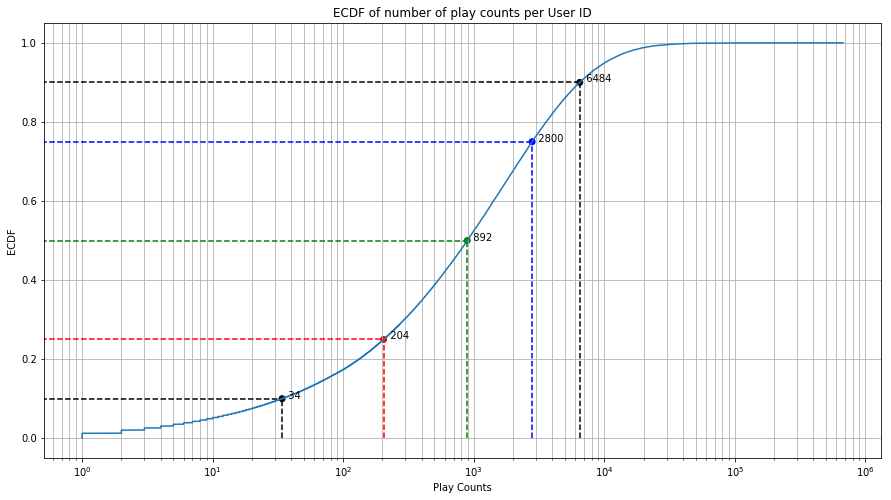

In [8]:
pdf = pd.DataFrame(data=userActivity)
Y = np.sort( pdf[1])
yvals = np.arange(len(Y))/float(len(Y))

# Calculate the percentiles at 25, 50, 75, 90 %
percentile = [10, 25, 50, 75, 90]
colors = ['black', 'red', 'green', 'blue', 'black']
rank = [int(x / 100 * (len(yvals) + 1)) for x in percentile]
rank_plot = [yvals[x] for x in rank]
percentiles_values_users = [Y[x] for x in rank]

plt.figure(figsize=(15, 8))

ax = plt.subplot()
ax.set_xscale("log")
plt.plot(Y, yvals)

# plot the percentiles lines and values
plt.scatter(percentiles_values_users,
            rank_plot, 
            c = colors,
            marker = 'o')
ax.vlines(percentiles_values_users, [0], rank_plot, color=colors, linestyle='--')
ax.hlines(rank_plot, [0], percentiles_values_users, color=colors, linestyle='--')
for i in range(len(rank_plot)):
    ax.annotate("  " + str(percentiles_values_users[i]), (percentiles_values_users[i], rank_plot[i]))
    
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()

<div class="alert alert-warning" align="justify">
The ECDF plot shows the distribution of the play counts over the users of the system. In this case the log scale has been used for the play count axis in order to better display the initial rapid increase of the function and visualize the percentiles.<br><br>

The main percentiles are marked in the plot in different colors, it is possible to notice that 90% of the users have a play count lower than 6484 which is approximately two orders of magnitude less than the maximum playcount.
Moreover between 25% and 75% it is possible to see an increase of just a little bit more than an order of magnitude.<br><br>

The long upper tail in the plot suggests the presence of outliers for which the play count is significantly higher than the median. If these users have a diversified spectrum of artists (later just called curiosity), then recommendations will probably be easier because the corresponding region in the utility matrix will be less sparse. However these data are distant from the other observations, therefore we should carefully choose whether to use them or not inside our model.<br><br>

It can also be noticed that 10% of the users has a very low play count (less than 33), which could later lead to difficulties in providing them good personalized recommendations (user cold start problem).<br>
It is hard for now to make any other comments regarding the influence of the data distribution on the recommender system.
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [9]:

# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupby("artistID").agg(sum("playCount").alias("sumPlaycount")).collect()

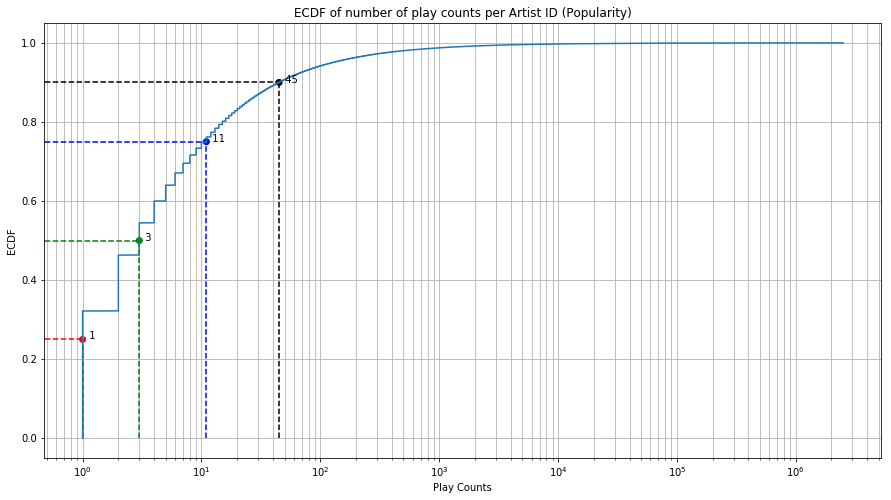

In [10]:
pdf = pd.DataFrame(data=artistPopularity)
Y = np.sort(pdf[1])
yvals = np.arange(len(Y))/float(len(Y))

# Calculate the percentiles at 25, 50, 75, 90 %
percentile = [25, 50, 75, 90]
rank = [int(x / 100 * (len(yvals) + 1)) for x in percentile]
percentiles_values_art = [Y[x] for x in rank]
rank_plot = [yvals[x] for x in rank]
colors = ['red', 'green', 'blue', 'black']

plt.figure(figsize=(15, 8))

ax = plt.subplot()
ax.set_xscale("log")

# plot the percentiles lines and values
plt.scatter(percentiles_values_art, 
            rank_plot,
            c = colors,
            marker = 'o')
ax.vlines(percentiles_values_art, [0], rank_plot, color=colors, linestyle='--')
ax.hlines(rank_plot, [0], percentiles_values_art, color=colors, linestyle='--')
for i in range(len(rank_plot)):
    ax.annotate("  " + str(percentiles_values_art[i]), (percentiles_values_art[i], rank_plot[i]))

plt.plot( Y, yvals)
plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID (Popularity)')
plt.show()

<div class="alert alert-warning" align="justify">
This ECDF plot shows the distribution of the play counts over the artists in the system. The log scale is required because of the great initial slope of the curve, even steeper than the previous one.<br><br>

The main percentiles are located in the left part of the curve, showing that 50% of the artists has a play count between 1 and 11. Moreover more than 25% of the artists have a play count of just one, only 10% has more than 45, and the play count keeps on growing dramatically towards the top artists.<br><br>

This kind of curve may be due not only to big differences in artists popularity, but also to the presence of dirty data: mispelled artist, probably focused on the lowest part of the curve.<br>
Furthermore, the system will prefer more popular artist to the one with low count, limiting recommendations to just a very small fraction of the artists.<br><br>

This last issue is the second embedded limitation of recommendation systems that use an implicit approach based on collaborative filtering.<br>
A possible solution could be the addition of a content-based component to the recommender system in order to alleviate the issue using a similarity metric between items.
</div>

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

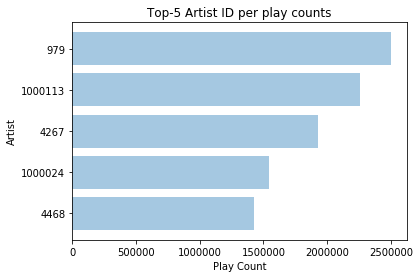

In [11]:
sortedArtist = sorted(artistPopularity, key = lambda x: -x[1])[:5]

artistID = [w[0] for w in sortedArtist]
y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()

<div class="alert alert-warning" align="justify">
The results displayed in the bar chart above seem reasonable. They show how top artists have extremely higher play counts compared to the others and, just considering the first five, it's possible to see how quickly the play counts decrease moving away from the head of the rank.<br><br>

With this said, it's clear that these data cannot be considered as representative for the whole dataset, since the top five artists surely reside in the long upper tail of the artists play count ECDF plot, which could be interpreted as outliers. However, in this particular case, outliers are just artists more popular than the others, therefore we don't want to remove them but attention must be paid when giving recommendations because we could risk to recommend only famous artists.
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [12]:
customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("Name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistDF.cache()

display(artistDF.limit(10).toPandas())

,artistID,Name
0,1134999,06Crazy Life
1,6821360,Pang Nakarin
2,10113088,"Terfel, Bartoli- Mozart: Don"
3,10151459,The Flaming Sidebur
4,6826647,Bodenstandig 3000
5,10186265,Jota Quest e Ivete Sangalo
6,6828986,Toto_XX (1977
7,10236364,U.S Bombs -
8,1135000,artist formaly know as Mat
9,10299728,Kassierer - Musik für beide Ohren


#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [13]:
# get artists whose name contains "Aerosmith"
Aerosmith_Names = artistDF[locate("Aerosmith", artistDF.Name) > 0]
display(Aerosmith_Names.limit(20).toPandas())

# show two examples
aero_artist = artistDF[artistDF.artistID==1000010]
display(aero_artist.limit(1).toPandas())

aero_artist = artistDF[artistDF.artistID==2082323]
display(aero_artist.limit(1).toPandas())

,artistID,Name
0,10586006,Dusty Springfield/Aerosmith
1,6946007,Aerosmith/RunDMC
2,10475683,Aerosmith: Just Push Play
3,1083031,Aerosmith/ G n R
4,6872848,"Britney, Nsync, Nelly, Aerosmith,Mary J Blige."
5,10586963,Green Day - Oasis - Eminem - Aerosmith
6,10028830,The Aerosmith Antology2
7,10300357,Run-DMC + Aerosmith
8,2027746,Aerosmith by MusicInter.com
9,1140418,[rap]Run DMC and Aerosmith


,artistID,Name
0,1000010,Aerosmith


,artistID,Name
0,2082323,01 Aerosmith


<div class="alert alert-warning" align="justify">
The IDs 1000010 and 2082323 clearly refer to the same artist. Dirty input data have a bad influence on the recommendation system, leading to poor results. Moreover, cleaning the data could decrease the amount of artists having play count equal to one while increasing the others, resulting in a more fair distribution.<br><br>

In the list above, many different mispelled names have been found for the Aerosmith (e.g. "Aerosmith hits", "Aerosmith by MusicInter.com"). In this particular example it can be noticed how Aerosmith and Run MDC appear together in multiple entries, due to mispells and the fact that the names are connected by different characters (comma, &, ft., /). This suggests that the featuring of multiple artists is a major problem because a single record should increase the play count of every artist participating.
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [14]:
customSchemaAlias = StructType([ \
    StructField("mispelledID", LongType(), True), \
    StructField("standardID", LongType(), True)])

artistAliasDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t') \
    .load(base + "artist_alias.txt", schema = customSchemaAlias) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
artistAliasDF.cache()

display(artistAliasDF.limit(5).toPandas())

,mispelledID,standardID
0,1092764,1000311
1,1095122,1000557
2,6708070,1007267
3,10088054,1042317
4,1195917,1042317


#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [15]:
display(artistAliasDF[artistAliasDF.mispelledID == 1000010].toPandas())
display(artistAliasDF[artistAliasDF.mispelledID == 2082323].toPandas())

# 1000010 is a standard id, so it hasn't been considered as mispelled id in the dataset

,mispelledID,standardID


,mispelledID,standardID
0,2082323,1000010


### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [16]:
artistAlias = artistAliasDF.rdd.map(lambda row: ( row[0] , row[1] )).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [17]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)

t1 = time()

display(newUserArtistDF.limit(5).toPandas())

print('The script takes %f seconds' %(t1 - t0))

,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314


The script takes 0.773734 seconds


#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [18]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)

t1 = time()

display(newUserArtistDF.limit(5).toPandas())

print('The script takes %f seconds' %(t1-t0))
newUserArtistDF = newUserArtistDF.cache()

,userID,artistID,playCount
0,1000002,1,55
1,1000002,1000006,33
2,1000002,1000007,8
3,1000002,1000009,144
4,1000002,1000010,314


The script takes 0.028162 seconds


Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

## Further cleaning
<div class="alert alert-warning" align="justify">
As already stated above, at the beginning of question 4, this first data cleaning step may not be enough to get the final (clean) data.<br>
In order to check if some other cleaning has to be done, some analysis have to be conducted on the data. A good starting point is the artistAlias dataset because it is then used to clean the other one.
</div>
### Cleaning the artistAlias dataset

In [19]:
# Count the number of mispelled ID that remap on mispelledID
standardID_column = artistAliasDF.select(artistAliasDF.standardID.alias("ID"))
misID_column = artistAliasDF.select(artistAliasDF.mispelledID.alias("ID"))
n_remapping_mis = standardID_column.intersect(misID_column).count()
print("The intersection between the columns contains %d values" % (n_remapping_mis))

The intersection between the columns contains 45 values


<div class="alert alert-warning" align="justify">
Since the intersection between the two columns of the dataset in not an empty set, some mispelled IDs will be mapped to standard IDs that are mispelled too. This means that there are either mispelled IDs mapping to the same value or chains of mispelled ID - standard ID.<br>
In order to iterate to remove the chains (supposing they are not loops) it is necessary to start by removing the IDs belonging to the first case.
</div>
#### I case: mispelledID == standardID

In [20]:
# show artist names corresponding to anomalies in the dataset where mispelledID == standardID
selfLoopAliasDF = artistAliasDF[artistAliasDF.mispelledID == artistAliasDF.standardID]
selfLoopAliasDF = selfLoopAliasDF.join(artistDF, selfLoopAliasDF.standardID==artistDF.artistID).select(selfLoopAliasDF.mispelledID, selfLoopAliasDF.standardID, artistDF.Name)
display(selfLoopAliasDF.toPandas())

# remove this values
selfLoopAliasList = selfLoopAliasDF.select(selfLoopAliasDF.standardID).rdd.map(lambda x: x[0]).collect()
cleanArtistAliasDF = artistAliasDF[artistAliasDF.mispelledID.isin(selfLoopAliasList) == False]
cleanArtistAlias = cleanArtistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

,mispelledID,standardID,Name
0,1014609,1014609,Mötley Crüe
1,1008798,1008798,µ-Ziq
2,1014175,1014175,Señor Coconut
3,1006322,1006322,múm
4,1006347,1006347,Dälek
5,1167860,1167860,Herman Düne
6,754,754,Sigur Rós
7,1013851,1013851,Värttinä
8,1018110,1018110,Lars Winnerbäck
9,1001864,1001864,Röyksopp


<div class="alert alert-warning" align="justify">
It can be noticed how this anomaly was probably due to the presence of unusual characters (greek or accented letters).<br>
</div>

#### II case: standardIDs as mispelledIDs [chains]

<div class="alert alert-warning" align="justify">
Now it is possible to correct the mispelled ID - standard ID chains too.<br>
A trivial solution to this problem would have been to repeat multiple times the replaceMispelledIDs operations used above. A more efficient solution is to clean the artistAlias dictionary and then clean the userArtist dataset in just one iteration.<br>
The process of cleaning the dictionary can be improved itself by iterating only on the IDs belonging to the chains.
</div>

In [21]:
# find IDs being part of chains
misID_columnDF = cleanArtistAliasDF.select(cleanArtistAliasDF.mispelledID.alias("ID"))
standardID_columnDF = cleanArtistAliasDF.select(cleanArtistAliasDF.standardID.alias("ID"))
chainsDF = standardID_columnDF.intersect(misID_columnDF)
chains_list = chainsDF.rdd.map(lambda x: x[0]).collect()
chains = {k: v for k, v in cleanArtistAlias.items() if v in chains_list}

In [22]:
# correct the dictionary values by removing chains
for k, v in chains.items():
    # while the value is also a key of the dictionary substitute the corresponding value
    while cleanArtistAlias.get(v) is not None:
        cleanArtistAlias[k] = cleanArtistAlias.get(v)
        v = cleanArtistAlias.get(k)
        
# update the dataframe
bcleanArtistAlias = sc.broadcast(cleanArtistAlias)

cleanArtistAliasDF = sqlContext.createDataFrame(
    cleanArtistAliasDF.rdd.map(lambda x: (x[0], bcleanArtistAlias.value.get(x[0]))), 
    customSchemaAlias
)

### Cleaning the userArtist dataset

<div class="alert alert-warning" align="justify">
The artistAlias dataset is clean, a final check on the intersections will be done to make sure that only one step will be needed to clean the userArtist dataset.<br>
During the final cleaning, it can be useful (even if computationally expensive) to keep track of the number of unique user IDs. At the beginning of the notebook there were 1631028 different values.
</div>

In [23]:
standardID_columnDF = cleanArtistAliasDF.select(cleanArtistAliasDF.standardID)
misID_columnDF = cleanArtistAliasDF.select(cleanArtistAliasDF.mispelledID)
n_remapping_mis = standardID_columnDF.intersect(misID_columnDF).count()
print("The intersection between the columns contains %d values" % (n_remapping_mis))

The intersection between the columns contains 0 values


In [24]:
uniqueArtists = newUserArtistDF.select("artistID").agg(countDistinct("artistID")).collect()
print("Total n. of artists: ", uniqueArtists[0][0])

Total n. of artists:  1568126


In [25]:
def replaceMispelledIDs(fields):
    finalID = bcleanArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)
newUserArtistDF.show(5)

newUserArtistDF = newUserArtistDF.cache()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
+-------+--------+---------+
only showing top 5 rows



In [26]:
uniqueArtists = newUserArtistDF.select("artistID").agg(countDistinct("artistID")).collect()
print("Total n. of artists: ", uniqueArtists[0][0])

Total n. of artists:  1568117


<div class="alert alert-warning" align="justify">
Unfortunately, the number of distinct artist IDs decreases by an ephemeral value. In front of a result like this, it is good to keep in mind that a cleaner dataset is always a good result, especially in building a recommender system, because each rating value may influence the others.<br><br>

After this cleaning step, the new dataframe may have multilple entries for the user-artist pairs, therefore it is needed to sum the corresponding play counts.
</div>

In [27]:
# Find duplicate pairs userID-artistID
duplicates=newUserArtistDF.groupBy("userID", "artistID").agg(count("playCount").alias("n_instances"))
duplicates=duplicates[duplicates.n_instances > 1]
display(duplicates.limit(5).toPandas())

,userID,artistID,n_instances
0,1000072,1009302,2
1,1000594,2073327,2
2,1000647,1263049,2
3,1000783,1013068,2
4,1000903,1013068,2


In [28]:
# Sum play counts of user-artist duplicate pairs
newUserArtistDF = newUserArtistDF.groupBy("userID", "artistID").agg(sum("playCount").alias("playCount"))

<div class="alert alert-warning" align="justify">
In order to get a measure of the final cleanliness of the dataset, the 'Aerosmith case' could be analized looking for other clues regarding a dirty dataset.
</div>

In [29]:
n_aerosmith_mis = cleanArtistAliasDF[cleanArtistAliasDF.standardID=="1000010"].count()
print("Mispelled artist names for Aerosmith: %d" % (n_aerosmith_mis))

Mispelled artist names for Aerosmith: 130


In [30]:
n_artists_containing_aerosmith = artistDF.join(newUserArtistDF, newUserArtistDF.artistID==artistDF.artistID, "inner")[locate("Aerosmith", "Name") > 0]\
                                .select(artistDF.artistID, artistDF.Name).distinct().count()
    
print("Artist names containing 'Aerosmith': %d" % (n_artists_containing_aerosmith))

Artist names containing 'Aerosmith': 244


<div class="alert alert-warning" align="justify">
Since the number of artist names containing 'Aerosmith' is greater than the number of known mispelled artist names linked to Aerosmith, we can deduce that, even if there were no more mispelled names (very unlikely), the 'featuring artist problem' seen before still has a big impact and the final user artist dataset remains dirty.
</div>

### The ["unknown"] case

<div class="alert alert-warning" align="justify">
A final analysis can be conducted on other anomalies found in the dataset: after running the recommender system, an artist with name '\[unknown\]' has been discovered.
</div>

In [31]:
unknownID = artistDF[artistDF.Name=="[unknown]"].collect()[0][0]
unknownMispIDs = artistDF.join(artistAliasDF[artistAliasDF.standardID == unknownID],
                               artistDF.artistID == artistAliasDF.mispelledID)\
                         .select(artistDF.Name, artistAliasDF.mispelledID, artistAliasDF.standardID)
unknown_count = unknownMispIDs.count()
print("There are " + str(unknown_count) + " artists mapping to the '[unknown]' standardID")
display(unknownMispIDs.limit(20).toPandas())

There are 955 artists mapping to the '[unknown]' standardID


,Name,mispelledID,standardID
0,新しいアーティスト (313),10299731,1034635
1,New Artist (275),1240704,1034635
2,e36137f5d3532d89be322de180fa0d8109,1135779,1034635
3,@@@Tag Me,6776105,1034635
4,f16baa8a5d7906c4d124a3a5312e6e2109,1135920,1034635
5,track13 unknown,1241058,1034635
6,track14 unknown,1241060,1034635
7,track15 unknown,1241061,1034635
8,track16 unknown,1241062,1034635
9,-------,10025238,1034635


<div class="alert alert-warning" align="justify">
The table above shows some of the 955 artist IDs mapping to the '[unknown]' standard ID. The number of mappings together with their names constitute a measure of how 'corrupted' is this ID because a lot of potentially different real artists are mapped to it.<br><br>

The best precaution that can be taken is to remove this data, this will lead to a cleaner data set and, most of all, it will probably reduce the number of artists having only one play count which where almost 35%. Moreover this will allow the model to produce better recommendations because the artists with just one play count are one of the factors of the sparsity of the utility matrix.
</div>

In [32]:
newUserArtistDF = newUserArtistDF[newUserArtistDF.artistID != unknownID]

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [34]:
uniqueArtists = newUserArtistDF.select("artistID").agg(countDistinct("artistID")).collect()
print("Total n. of artists: ", uniqueArtists[0][0])

Total n. of artists:  1568116


<div class="alert alert-warning" align="justify">
As we can see, though the cleaning of the dataset we passed from 1631028 to 1568116 artists. A great part of corrections were included in the artist_alias.txt without corrections. Few others taking into account "chains". Lastly the ["unknown"] user was removed. More details are provided in the section above [Further Cleaning](#Further Cleaning).
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

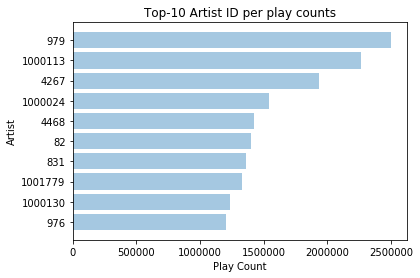

In [35]:
# Build the dataset of Artist - TotPlaycount (for later use)
ArtistsByPc = newUserArtistDF.groupBy("artistID").agg(sum("playCount").alias('playCount')).orderBy('playCount', ascending=0)

# 
ArtistsByPcOld = userArtistDF.groupby("artistID").agg(sum("playCount").alias("Playcount")).orderBy('playCount', ascending=0).take(10)

# Calculate top-10 artists in term of play counts
Top10ArtistsByPc = ArtistsByPc.take(10)

y_pos = range(len(Top10ArtistsByPc))
pdf = pd.DataFrame(data=Top10ArtistsByPc)

# Plot the bar chart
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')

plt.show()

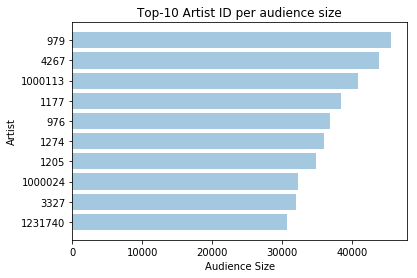

In [36]:
# Build the dataset of Artist - Audience Size (for later use)
ArtistsByAs = newUserArtistDF.groupBy("artistID").agg(countDistinct("userID").alias("audience_size")).orderBy('audience_size', ascending=0)

# calculate top-10 artists in term of audience size
top10ArtistsByAs = ArtistsByAs.take(10)

y_pos = range(len(top10ArtistsByAs))
pdf = pd.DataFrame(data=top10ArtistsByAs)

# Plot the bar chart
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Audience Size')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()

<div class="alert alert-warning" align="justify">
As we can see, the ranking of artists by audience size and play count are pretty similar. 
As popular artists are also very listened artists, we could suspect that these two features have good correlation. Anyway, it would be wrong to state it only looking at the top 10 because they could not represent the behaviour of all the artist population.
However, the correlation graphs that will be plotted later will confirm this hypothesis.
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

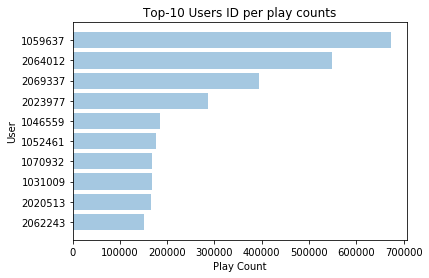

In [37]:
# Build the dataset of UserId - TotPlaycount (for later use)
UsersByPc = newUserArtistDF.groupBy("userID").agg(sum("playCount").alias("TotPlayCount")).orderBy("TotPlayCount", ascending=0)

# calculate top 10 users interm of play counts
top10UsersByPlayCount = UsersByPc.take(10)

y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)

# Plot the bar chart
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

In [38]:
# Build the dataset of Artist - Curiosity (for later use)
UsersByCur =newUserArtistDF.groupBy("userID").agg(countDistinct("artistID").alias("curiosity")).orderBy('curiosity', ascending=0)

# calculate top 10 users interm of curiosity
top10UsersByCuriosity =UsersByCur.take(10)

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

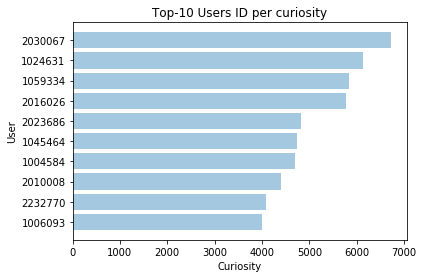

In [39]:
# Plot the bar chart
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Curiosity')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

<div class="alert alert-warning" align="justify">
For the users we cannot apply the same considerations made for the artists. In fact the two rankings are completely different. So we can suspect there are two types of users. One kind of users that listens only to few artists several times and another which listens just few times several artists. Of course, as said before, we cannot make conclusions only looking at the top 10 users. The correlation graph will help to understand the situation.
</div>

# Correlation graphs

<div class="alert alert-warning" align="justify">
For a better understanding of our datasets, it is convenient to plot correlation graphs. These want to show the correlation between users properties (Playcount and Curiosity) and artist properties (Playcount and Audience size). The aim here is to understand if there is a trend that links every two properties and to see the presence of outliers in different dimensions (more details are provided later).
</div>

In [40]:
# Prepare the dataset for the plot of the correlation graph
df_ArtistsPcVsAs = ArtistsByAs.join(ArtistsByPc, ArtistsByAs.artistID == ArtistsByPc.artistID)\
                                .select(ArtistsByAs.audience_size, ArtistsByPc.playCount)\
                                .collect()

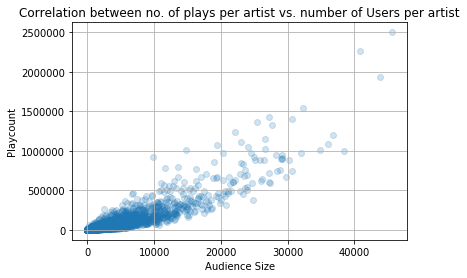

In [41]:
# Plot the correlation graph
plt.title('Correlation between no. of plays per artist vs. number of Users per artist')
plt.xlabel('Audience Size')
plt.ylabel('Playcount')

plt.scatter([x[0] for x in df_ArtistsPcVsAs],[x[1] for x in df_ArtistsPcVsAs], alpha=0.2)
plt.grid()
plt.show()

<div class="alert alert-warning" align="justify">
As we can observe from the graph, a correlation between the Audience size (popularity) with the total number of play count exists. If the two parameters where completely correlated we would have obtained a straight line, that is for every artist we wold have a constant ratio between the play count and audience size.
As the points seem to place on a straight line, we can conclude that these two parameters are higly correlated.
So we can state that artists with a high number of play counts have also a big number of users.
</div>

In [42]:
# Prepare the dataset for the plot of the correlation graph
df_UsersPcVsCur = UsersByCur.join(UsersByPc, UsersByCur.userID == UsersByPc.userID)\
                            .select(UsersByCur.curiosity, UsersByPc.TotPlayCount)\
                            .collect()

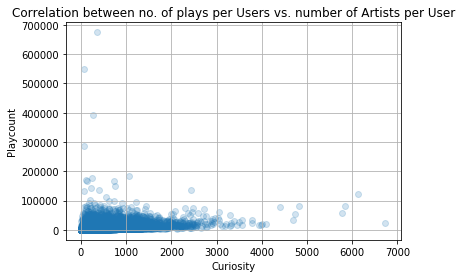

In [43]:
# Plot the correlation graph
x = np.array( [x[0] for x in df_UsersPcVsCur] )
y = np.array( [x[1] for x in df_UsersPcVsCur] )

plt.title('Correlation between no. of plays per Users vs. number of Artists per User')
plt.xlabel('Curiosity')
plt.ylabel('Playcount')

plt.scatter(x,y, alpha=0.2)
plt.grid()
plt.show()

<div class="alert alert-warning" align="justify">
In this case, the Correlation plot for the User Artist does not show an evident trend between Curiosity and Play count as instead happened in the artist case, even if a little bit less evident than with the artist case. However, we notice that there are strange cases where either for very low curiosity level there is an high playcount or the opposite. For the latter, it seems like that the playcount is almost equal to the curiosity, this means that user has listened to many artist only once (or just few times).<br>
Clearly, we can put an end to users curiosity, and suppose that this is simply a Bot. Same hypothesis can be applied to the users which have listened a lot of times to very few artists (or even only one).<br>
Since these data are outliers, it could be good to exclude them from the analysis. More details are given in [Experimental explorations](## 4 Experimental explorations)
</div>

Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix} =
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerical values, we can return a special tuple. After that, we can filter out these special tuples.

In [33]:
rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map(xtractFields)
    
                    # fileter out the special tuples
                    .filter(lambda x: x[0] != -1 and x[1] != -1)
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )

#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast varible can help us increase the effiency.

<div class="alert alert-warning" align="justify">
We used "cleanArtistAlias" instead of "artistAlias" to have a better cleaning (see Question 4.4).
</div>

In [34]:
bArtistAlias = sc.broadcast(cleanArtistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(int(artistID), artistID)
    return (int(userID), int(finalArtistID), int(count))

userArtistDataRDD = rawUserArtistData.map(disambiguate)
userArtistDataRDD.take(5)

[(1000002, 1, 55),
 (1000002, 1000006, 33),
 (1000002, 1000007, 8),
 (1000002, 1000009, 144),
 (1000002, 1000010, 314)]

In [35]:
# Verify correctness of the algorithm
n_mispelled_id = userArtistDataRDD.filter(lambda x: x[1] in bArtistAlias.value.keys()).count()
print("There are %d known mispelled ID in the dataset" % (n_mispelled_id))

There are 0 known mispelled ID in the dataset


In [36]:
# Remove artist unknown and those mapped to it (id 1034635)
userArtistDataRDD = userArtistDataRDD.filter(lambda x: x[1] != 1034635)

## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [37]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [38]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
from operator import add

# creat the dataset
allData = (
    userArtistDataRDD.map(lambda x: ((x[0], x[1]), x[2]))
                    .reduceByKey(add)
                    .map(lambda r: Rating(r[0][0], r[0][1], r[1]))
                    .repartition(4) # 4 Because we are working with a dataframe with 4 workers. Any multiple of 4 is fine.
                    .cache()
)

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [39]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 268.909730 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [51]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model_one.spark
model.save( sc , "lastfm_model_one.spark")

Deleted lastfm_model_one.spark


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [52]:
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model_one.spark")
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))

finish loading model in 1.554451 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [53]:
model.userFeatures().take(1)

[(116,
  array('d', [0.04625478386878967, 0.002051145303994417, 0.03604276478290558, -0.012370210140943527, -0.035896144807338715, 0.0026291818358004093, -0.02532508783042431, -0.010397730395197868, -0.01702127605676651, -0.06826016306877136]))]

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [54]:
# Make five reccommendations to user 2093760
recommendations = (model.recommendProducts(2093760, 5))

# construct set of recommendated artists
recArtist = set([x.product for x in recommendations])

In [40]:
# construct data of artists (artist_id, artist_name)
rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)

In [56]:
# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0] in recArtist):
        return True
    else:
        return False

recList = artistByID.filter(artistNames).values().collect()

print(recList)

['50 Cent', 'Snoop Dogg', 'Dr. Dre', '2Pac', 'The Game']


<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [41]:
def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  
unpersist(model)

## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [58]:
trainData, cvData = allData.randomSplit([9,1])
trainData.cache()
cvData.cache()

PythonRDD[572] at RDD at PythonRDD.scala:48

In [59]:
t0 = time()
model = ALS.trainImplicit( trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 69.716774 secs


#### Area under the ROC curve: a function to compute it

In [42]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [43]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        
        IDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(IDs) and len(negative) < len(posItemIDSet)):
            itemID = IDs[randint(0,len(IDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [62]:
t0 = time()
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.965386645077415
finish in 47.889809 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the AUC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [63]:
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(add).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1], 0.0)))

In [64]:
auc = calculateAUC(cvData, bAllItemIDs, predictMostListened)
print(auc)

0.9389414483994514


<div class="alert alert-warning" align="justify">
The result obtained by using the simpler approach is close to the one obtained preaviously because if most of the users like one artist, then it is very likely that the others will too, also because the model we use is 'biased' towards artist with higher playcounts and the playcount difference between the most played artists and the others is very wide.<br><br>

Anyway, this approach will perform very bad for artist that have a very high play count but a low audience, meaning that they are not really popular and so only a few of the users will like them. This last sentence drives us to a last assumption: with a larger and cleaner dataset, the performance of the most-played artist approach would still be good, but not as good as in this case because there would be more heterogeneity in the users' musical tastes.
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given parameters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [65]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit( trainData, rank=rank, iterations=5, lambda_= lambda_, alpha=alpha )
            
            auc = calculateAUC(cvData , bAllItemIDs, model.predictAll)
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000


In [66]:
evaluations.sort(key=lambda x: x[1], reverse=True)
                 
evalDataFrame = pd.DataFrame(data=evaluations)
display(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

,0,1
0,"(50, 1.0, 40.0)",0.977154
1,"(10, 1.0, 40.0)",0.976875
2,"(10, 0.0001, 40.0)",0.976246
3,"(50, 0.0001, 40.0)",0.975588
4,"(10, 1.0, 1.0)",0.970261
5,"(50, 1.0, 1.0)",0.966759
6,"(10, 0.0001, 1.0)",0.966322
7,"(50, 0.0001, 1.0)",0.954035


PythonRDD[572] at RDD at PythonRDD.scala:48

<div class="alert alert-warning" align="justify">
After running the above evaluation multiple times it can be noticed how the best alpha parameter is always 40 while the other optimal parameters (especially lambda) tend to vary between different executions.<br><br>

An initially unexpected result is rank = 10 because it could be thought that the more the latent features, the more accurate the results. But actually this is not true (as the results show) because more latent features meand a more complex error function to optimize, and therefore more local minima.
</div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [44]:
params=[50, 1.0, 40.0]
model = ALS.trainImplicit(ratings=allData, rank=params[0], iterations=5, lambda_=params[1], alpha=params[2])
allData.unpersist()

def artistNames(line):
#     [artistID, name]
    if (line[0] in recommendedProductIDs):
        return True
    else:
        return False

userID = 2093760
recommendations = model.recommendProducts(userID, 5)
recommendedProductIDs = set([x.product for x in recommendations])
recList = artistByID.filter(artistNames).values().collect()
print(recList)

unpersist(model)

['50 Cent', 'Jay-Z', 'Kanye West', '2Pac', 'Eminem']


<div class="alert alert-warning" align="justify">
We might want to save this model, with the optimized hyper-parameters to use it in the next session where we're are going to test some other techniques.
</div>

In [45]:
! hdfs dfs -rm -R -f -skipTrash lastfm_model_best.spark
model.save( sc , "lastfm_model_best.spark")

Deleted lastfm_model_best.spark


## 4 Experimental explorations

### 4.1 Outliers 

<div class="alert alert-warning" align="justify">
As already stated in the first part of the notebook, a clean dataset is foundamental in order to get good result from the model.
In this section we analised the dataset and removed some outliers, finally we evaluated again the model to look for any improvement.<br><br>

In order to find outliers, it is needed to define a metric and a threshold over it. We first analysed the users distribution in terms of total play count and then in terms of curiosity.<br>
A similar analysis could be done over the artists too in terms of total play count and audience size but, in this case, removing ouliers would just mean eliminating the most popular artists from the dataset which would not lead to more correct recommendations (we have already seen in question 9.3 that a model using the most popular artists gives quite good results).
</div>

### 4.1.1 Remove outliers by play count

<div class="alert alert-warning" align="justify">
In this section we remove the outliers users by total play count. The threshold used is one order of magnitude bigger than the 90th percentile because it fits better the definition of outliers: there are very few users above that threshold and their play count are very far from the rest of the distribution.<br><br>

We suppose the system recommendations will improve because, even if there are just few outliers, their values could strongly condition the model (in 4.2 we suggest another way to smooth the differences in the ranking values).<br>
A possible hypothesis regarding the origin of such high play counts is that the corresponding users are actually bots, therefore they need to be removed from the recommendation system.
</div>

In [69]:
# find users that are not outliers and display the new count
percentile90 = int(percentiles_values_users[-1])
outlier_value = percentile90*10

NoOutliersDF_playC = (
    newUserArtistDF.groupBy("userID")
                    .agg(sum("playCount").alias("TotPlayCount"))
                    .orderBy("TotPlayCount", ascending=0)
)
NoOutliersDF_playC = NoOutliersDF_playC[NoOutliersDF_playC.TotPlayCount < outlier_value]

new_count = NoOutliersDF_playC.agg(countDistinct("userID")).collect()

print("Now the dataset contains No. " + str(new_count[0][0]) + " Users")

Now the dataset contains No. 148012 Users


In [70]:
# remove outliers from the UserArtist dataset
UserArtistNoOutliers = newUserArtistDF.join(NoOutliersDF_playC, NoOutliersDF_playC.userID==newUserArtistDF.userID, "inner")\
    .select(newUserArtistDF.userID, newUserArtistDF.artistID, newUserArtistDF.playCount).rdd.map(lambda x: (x[0], x[1], x[2]))
    

In [59]:
# define a function to prepare the dataset for the evaluation in order to reuse the previously defined calculateAUC function
def prepare_model(dataset, mapRating = lambda r: Rating(r[0], r[1], r[2]), rank=50, iterations=5, lambda_=1.0, alpha=40.0):    
    allData = dataset.map(mapRating).repartition(4).cache()
    
    # separate dataset to get a training set and a test set
    trainData, cvData = allData.randomSplit([9,1])
    trainData.cache()
    cvData.cache()    
    
    # create model
    model = ALS.trainImplicit(trainData, rank = rank, iterations = iterations, lambda_ = lambda_, alpha = alpha)
    trainData.unpersist()
    
    # get all unique artistId
    allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
    
    return model, allItemIDs, cvData

In [72]:
model, allItemIDs, cvData = prepare_model(UserArtistNoOutliers, rank=params[0], iterations=5, lambda_=params[1], alpha=params[2])
bAllItemIDs = sc.broadcast(allItemIDs)

# calculate area under the curve
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
cvData.unpersist()

print("AUC = " + str(auc))

AUC = 0.9767328867089502


### 4.1.2 Remove outliers by curiosity

<div class="alert alert-warning" align="justify">
The curiosity can also be considered a dimension over which we can find outliers. The threshold chosen is again 10 times more than the 90 percentile of the curiosity ECDF.<br><br>

In this case an abnormal value of curiosity could still affect our model: an high level of curiosity could lead a user to be similar to too many users. When applying a collaboratorive filtering approach, this can lead to the identification of false "trends".<br><br>

Let's consider an example: if we want to make recommendations for a user which likes Rock music, these could be affected also by "curiosity outliers" which could like many music's genres. In the extreme case, the model could predict music uncorrelated to the original tastes of the user, because it consideres him similar to the outliers.<br><br>

Moreover, the same consideration made for the play count outliers can be made in this case: given the too high number of different artists listened by a single user, it could be just a bot.
</div>

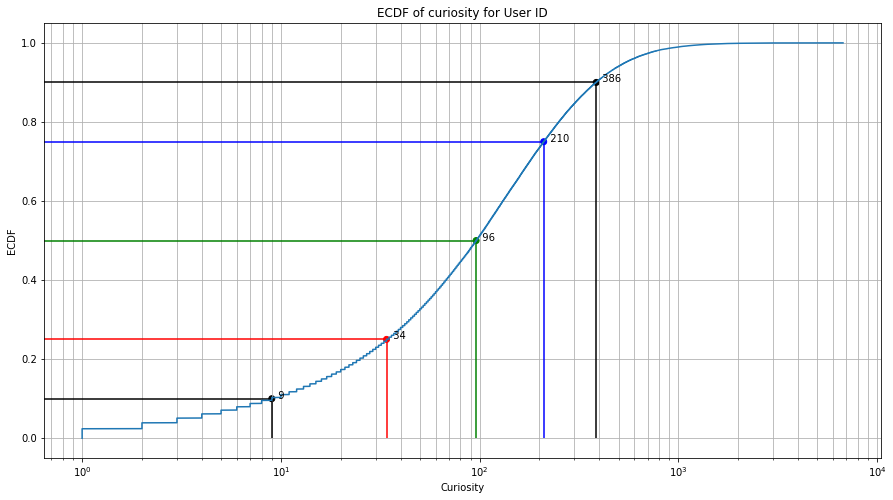

In [73]:
# calculate dataset of users in terms of curiosity
UsersByCuriosity = (
    newUserArtistDF.groupBy("userID")
                    .agg(countDistinct("artistID").alias("curiosity"))
                    .orderBy('curiosity', ascending=0)
                    .collect()
)

pdf = pd.DataFrame(data=UsersByCuriosity)

# plot the ECDF of the curiosity
Y = np.sort( pdf[1])
yvals = np.arange(len(Y))/float(len(Y))

percentile = [10, 25, 50, 75, 90]
colors = ['black', 'red', 'green', 'blue', 'black']
rank = [int(x / 100 * (len(yvals) + 1)) for x in percentile]
rank_plot = [yvals[x] for x in rank]
percentiles_values_users_curiosity = [Y[x] for x in rank]

plt.figure(figsize=(15, 8))

ax = plt.subplot()
ax.set_xscale("log")

plt.plot(Y, yvals)
plt.scatter(percentiles_values_users_curiosity,
            rank_plot, 
            c = colors,
            marker = 'o')
ax.vlines(percentiles_values_users_curiosity, [0], rank_plot, color=colors)
ax.hlines(rank_plot, [0], percentiles_values_users_curiosity, color=colors)
for i in range(len(rank_plot)):
    ax.annotate("  " + str(percentiles_values_users_curiosity[i]), (percentiles_values_users_curiosity[i], rank_plot[i]))
plt.xlabel('Curiosity')
plt.ylabel('ECDF')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of curiosity for User ID')
plt.show()

In [74]:
# calculate top 10 users in terms of curiosity
percentile90 = int(percentiles_values_users_curiosity[-1])
outlier_value = percentile90*10

NoOutliersDF_Cur = (
    newUserArtistDF.groupBy("userID")
                    .agg(countDistinct("artistID").alias("curiosity"))
                    .orderBy('curiosity', ascending=0)
)
NoOutliersDF_Cur = NoOutliersDF_Cur[NoOutliersDF_Cur.curiosity < outlier_value]
NoOutliers_Cur = NoOutliersDF_Cur.take(10)

new_count = NoOutliersDF_Cur.agg(countDistinct("userID")).collect()

print("Now the dataset contains No. " + str(new_count[0][0]) + " Users")

Now the dataset contains No. 148068 Users


In [75]:
# remove outliers from the dataset
UserArtistNoOutliersCur = newUserArtistDF.join(NoOutliersDF_Cur, NoOutliersDF_Cur.userID==newUserArtistDF.userID, "inner")\
    .select(newUserArtistDF.userID, newUserArtistDF.artistID, newUserArtistDF.playCount).rdd.map(lambda x: (x[0], x[1], x[2]))

In [76]:
# evaluate the model on the new dataset
model, allItemIDs, cvData = prepare_model(UserArtistNoOutliersCur, rank=params[0], iterations=5, lambda_=params[1], alpha=params[2])
bAllItemIDs = sc.broadcast(allItemIDs)

# calculate area under the curve
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
cvData.unpersist()

print("AUC = " + str(auc))

AUC = 0.976620870372506


<div class="alert alert-warning" align="justify">
As expected, in both cases the AUC value improves slightly, also because the actual already has good results considering its simple architecture and the not-so-clean dataset used.<br>
Moreover, some comments should be done regarding the evaluation of the model, they are provided in last section of this notebook: Summary.
</div>

### 4.2 Model using log of the rating

<div class="alert alert-warning" align="justify">
In our dataset the play counts of each pair userID-artistID may vary of many orders of magnitude from one to the other. In order to have a system which is more fair between artists that have different ratings, it is possible to use the logarithm of the play count as rating.
</div>

In [62]:
# get the dataset and prepare the model
cleanedArtistData = userArtistDataRDD.map(lambda x: ((x[0], x[1]), x[2])).reduceByKey(add)

model, allItemsID, cvData = prepare_model(cleanedArtistData, 
            mapRating = lambda r: Rating(r[0][0], r[0][1], 1+np.log(1+r[1])), 
            rank=params[0], 
            iterations=5, 
            lambda_=params[1], 
            alpha=params[2])

# evaluate the model using the log
#model, allItemIDs, cvData = prepare_model(cleanedArtistData, rank=params[0], iterations=5, lambda_=params[1], alpha=params[2])
bAllItemIDs = sc.broadcast(allItemIDs)

# calculate area under the curve
auc = calculateAUC( cvData , bAllItemIDs, model.predictAll)
cvData.unpersist()

print("AUC = " + str(auc))

AUC = 0.9827368996060983


<div class="alert alert-warning" align="justify">
As expected the regularization leads to a small variation of the UAC, it is not always an improvement because of the choice of training and validation sets. In the formula used, the addition of the constant 1, both inside and outside the log, helps to further reduce the ratio between high and low rating, and to deal with very low values.
</div>

### 4.3 Hybrid approach: Collaborative Filtering & Content-Based recommendations

#### 4.3.1 Clustering of users

<div class="alert alert-warning" align="justify">
The collaborative filtering approach gives us fair results, but it still has some limitations, it is too mechanical and simplistic. A good improvement to the actual recommendations could be to weight the final ratings on the ones of other users that have similar tastes. By doing so it is possible to recommend an user with an artist that probably doesn't match the other artists he listens to, but can anyway match his tastes.
</div>

In [46]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.clustering import KMeans, KMeansModel
from time import time
import matplotlib.pyplot as plt
from math import sqrt

In [47]:
# Load the best model obtained by ALS
t0 = time()
model = MatrixFactorizationModel.load(sc, "lastfm_model_best.spark")
t1 = time()
print("Took %d seconds to load the model" % (t1-t0))

Took 4 seconds to load the model


<div class="alert alert-warning" align="justify">
The proposed hybrid approach begins with the clustering of users features by using the k-means algorithm already implemented inside MLlib.<br>
Since it is hard to estimate a good number of clusters in the space of user features, we will try to execute the k-means algorithm with different numbers of clusters and apply the elbow rule by plotting the heterogeneity of each model.
</div>

In [48]:
# get the matrix of user features
userFeatures = model.userFeatures().map(lambda x: list(x[1]))

In [49]:
# train the k-means model for different values of k
kmeans_train_k = []
for i in range(2,40):
    print("Starting k-means with k=" + str(i), end="... ")
    clusters = KMeans.train(userFeatures, k = i)
    wssse = clusters.computeCost(userFeatures)
    kmeans_train_k.append([clusters, wssse])

Starting k-means with k=2... Starting k-means with k=3... Starting k-means with k=4... Starting k-means with k=5... Starting k-means with k=6... Starting k-means with k=7... Starting k-means with k=8... Starting k-means with k=9... Starting k-means with k=10... Starting k-means with k=11... Starting k-means with k=12... Starting k-means with k=13... Starting k-means with k=14... Starting k-means with k=15... Starting k-means with k=16... Starting k-means with k=17... Starting k-means with k=18... Starting k-means with k=19... Starting k-means with k=20... Starting k-means with k=21... Starting k-means with k=22... Starting k-means with k=23... Starting k-means with k=24... Starting k-means with k=25... Starting k-means with k=26... Starting k-means with k=27... Starting k-means with k=28... Starting k-means with k=29... Starting k-means with k=30... Starting k-means with k=31... Starting k-means with k=32... Starting k-means with k=33... Starting k-means with k=34... Starting k-means w

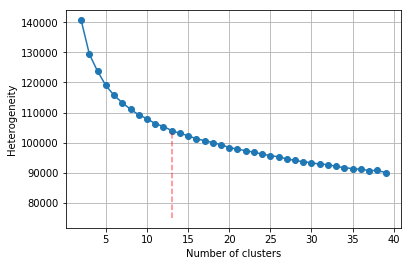

In [50]:
# plot the different heterogeneities
scores = [x[1] for x in kmeans_train_k]

plt.plot(range(2, len(kmeans_train_k)+2), scores, marker='o')
plt.plot([13, 13], [75000, scores[13-2]], c='r', ls='--', alpha=0.5)
plt.xlabel('Number of clusters')
plt.ylabel('Heterogeneity')
plt.grid()
plt.show()

<div class="alert alert-warning" align="justify">
From the plot it is possible to see that the curve does not really have an elbow shape but it's slope decreases particularly after k=13, therefore we suppose this is the optimal number of clusters.
</div>

In [83]:
# retrain the model with the correct number of clusters
clusters = KMeans.train(userFeatures, k = 13)

# get the labels with the user features
labelsRDD = clusters.predict(userFeatures)
ID_features = model.userFeatures().map(lambda x: (x[0], list(x[1])))
labels_featuresRDD = labelsRDD.zip(ID_features)

<div class="alert alert-warning" align="justify">
Now we need to take the top <i>nRelevantUsers</i> users belonging to the same cluster of the user we want to recommend and use their features to weight the final recommendation.
</div>

In [84]:
# user to recommend
userID = 2093760

# number of other users to consider in the recommendation
nRelevantUsers = 2

# find user's features and cluster label
userLabelFeatures = labels_featuresRDD.filter(lambda x: x[1][0] == userID).collect()[0]
userCluster = userLabelFeatures[0]
userFeatures = userLabelFeatures[1][1]

# get the center of the user' cluster
clusterCenter = np.array(clusters.clusterCenters[userCluster])

In [85]:
# get the features of the top N users by distance to the cluster center
closestUsersFeatures = (
    labels_featuresRDD.filter(lambda x: x[0] == userCluster) # get users belonging to the same cluster
                    .map(lambda x: x[1])                     # filter out the cluster label
                    .map(lambda x: (x[0], np.array(x[1])))   # make an np.array of user features
                    .map(lambda x: (np.linalg.norm(x[1] - clusterCenter), x)) # compute distance from the cluster center
                    .sortByKey()                             # sort by increasing distance
                    .map(lambda x: x[1][1])                  # get the user features only
                    .take(nRelevantUsers)                    # take the nRelevantUsers closer to the center
)

<div class="alert alert-warning" align="justify">
To weight the recommendation we just sum the features of each user (the recommended and the ones belonging to his cluster) and we take the average.<br>
Finally we obtain the ratings by multiplying the averaged user features for the productFeatures matrix and we recommend the top ratings.
</div>

In [86]:
# weight the recommmendations
sumOfFeatures = np.array(userFeatures)
for feats in closestUsersFeatures:
    sumOfFeatures += feats
finalFeatures = sumOfFeatures/(nRelevantUsers + 1)

# get the productFeatures matrix
productsFeatures = model.productFeatures().map(lambda x: (x[0], np.array(x[1])))

# broadcast the averaged user features to make the product with the product features
bFinalFeatures = sc.broadcast(finalFeatures)

def computeRating(features):
    return features.dot(bFinalFeatures.value)

recommendation = (
    productsFeatures.map(lambda x: (-computeRating(x[1]), x[0]))
                    .sortByKey()
                    .map(lambda x: x[1])
                    .take(5)
)

# get recommended artists names from their IDs
recList = artistByID.filter(lambda x: x[0] in recommendation).values().collect()
print(recList)

['Eminem', 'Outkast', 'Linkin Park', 'Green Day', 'Beastie Boys']


<div class="alert alert-warning" align="justify">
The final model provides us a degree of freedom: it is possible to decide wether to proceed with the standard recommendation (<i>nRelevantUsers = 0</i>) or to give more importance to the artists that are listened from users belonging to the same cluster (<i>nRelevantUsers > 0</i>).
</div>

#### 4.3.2 Features extraction

<div class="alert alert-warning" align="justify">
In order to further proceed in the implementation of the hybrid model, it is needed to have some content-based information.<br>
The file `artists_tags.txt` contains the tags associated to each artist, one artist per line. The format of the file is as follow
 * artistID, tag_1, score_1, tag_2, score_2, ..., tag_n, score_n
 * ...
 * artistID, tag_1, score_1, tag_2, score_2, ..., tag_m, score_m
 
where the score associated to each tag define how strong is the tag for that artist.<br><br>

First of all we want to extract from the file the list of all the relevant tags, where by relevant we mean a tag which is at least associated to 100 artists. Then we'll clean the dataset by keeping just the relevant tags for each artist.
</div>

In [51]:
# read tags file
tags_file = sc.textFile("artists_tags.txt")

# count occurrence of each tag
tags_count = tags_file.flatMap(lambda line: [(x.lower(), 1) for i, x in enumerate(line.split(", ")) if i%2==1]).reduceByKey(lambda a,b: a+b)

# filter out all tags that do not appear at least k times
tags_filtered = tags_count.filter(lambda x: x[1]>100)

# get the list of tags
tags = tags_filtered.map(lambda x: x[0])

In [52]:
print("Tags collected = " + str(tags_count.count()))
print("Tags filtered = " + str(tags_filtered.count()))

Tags collected = 146263
Tags filtered = 1925


In [53]:
# clean the artists tags dataset
bTags = sc.broadcast(tags.collect())

# for each artist create a tuple where the first value is the artistID, the second is a dictionary where key=tag, value=tag_score
artist_tags = (
    tags_file.map(lambda line: line.split(", "))
             .map(lambda x: (int(x[0]), {x[i]: int(x[i+1]) for i in range(1, len(x), 2)}))
)

<div class="alert alert-warning" align="justify">
In order to make recommendations it is needed to associate tags to users, each user will have all the tags of all the artists he listened to. The  informations on the score of each tag, which can be extremely useful to make precise recommendations, will be kept by summing all the scores relative to the same tag.<br>
However, since the user may have higher rating for an artist than another (i.e. higher play count), instead of performing a simple sum of the tags, we decided to implement a weighted sum of the scores, using the play count as weight of each of them.
</div>

In [54]:
from collections import Counter

def addTags(line):
    artist = b_artist_tags.value.get(int(line[1]), None)
    if artist is None:
        return None
    return int(line[0]), int(line[1]), int(line[2]), artist
    
b_artist_tags = sc.broadcast(artist_tags.collectAsMap())
users_file = sc.textFile("/datasets/lastfm/user_artist_data.txt")

# add tags of the artist to each pair user-artist. Output = (userID, artistID, playCount, dictionary<tag: weight>). Discard all entries for which tags are not available
user_artist_tags = users_file.map(lambda x: x.split(' ')).map(addTags).filter(lambda x: x is not None)

user_tags = (
    user_artist_tags.map(lambda x: (x[0], {k: v*x[2] for k, v in x[3].items()})) # Weight tags with playCount. Output = (userID, dictionary<tag: weight*playCount>)
                    .reduceByKey(lambda a, b: dict(Counter(a)+Counter(b))) # Merge dictionaries relative to the same user. Output = (userID, dictionary<tag: sum(weight*playCount)>)
)

In [55]:
# extract top 10 tags for each user
user_top_tags = user_tags.map(lambda x: (x[0], dict(sorted(x[1].items(), key=lambda y: -y[1])[:10]))) 

#### 4.3.3 Mixing the approaches
<div class="alert alert-warning" align="justify">
In order to be able to mix the approaches we need to make sure we are working on compatible data. Unfortunatly the artists tags dataset contains a very small number of artists, therefore, we will need to remove a big portion of the userArtist dataset.<br><br>
We now the importance of data, especially when doing applied machine learning, and we want to point out that we are using this dataset just to test the hybrid approach.
</div>

In [63]:
# get artist IDs present in the artist tags dataset
artistIDs = artist_tags.map(lambda x: x[0]).collect()

# since the list of artists in the artist tag dataset is small, it can be broadcasted
bArtistIDs = sc.broadcast(artistIDs)

# remove all entries from the userArtist dataset containing artists that are not in the artist tag dataset
filteredUserArtist = (
    cleanedArtistData.map(lambda x: (x[0][0], x[0][1], x[1]))
                     .filter(lambda x: x[1] in bArtistIDs.value)
                     .map(lambda r: Rating(r[0], r[1], r[2]))
                     .repartition(4)
                     .cache()
)

In [ ]:
# train a new model on the new dataset
model = ALS.trainImplicit(filteredUserArtist, rank=params[0], iterations=5, lambda_=params[1], alpha=params[2])

<div class="alert alert-warning" align="justify">
Now that we trained a new model with the filtered dataset we can apply clustering on the user features as before and then m
</div>

In [ ]:
# apply clustering

# get the matrix of user features
userFeatures = model.userFeatures().map(lambda x: list(x[1]))

# train the model with the an hypothetically correct number of clusters (due to time limits it is not possible to run again the elbow)
clusters = KMeans.train(userFeatures, k = 13)

# get the labels with the user features
labelsRDD = clusters.predict(userFeatures)
ID_features = model.userFeatures().map(lambda x: (x[0], list(x[1])))
labels_featuresRDD = labelsRDD.zip(ID_features)

# user to recommend
userID = 2093760

# number of other users to consider in the recommendation
nRelevantUsers = 2

# find user's features and cluster label
userLabelFeatures = labels_featuresRDD.filter(lambda x: x[1][0] == userID).collect()[0]
userCluster = userLabelFeatures[0]
userFeatures = userLabelFeatures[1][1]

# get the center of the user' cluster
clusterCenter = np.array(clusters.clusterCenters[userCluster])

# get the features of the top N users by distance to the cluster center
closestUsersFeatures = (
    labels_featuresRDD.filter(lambda x: x[0] == userCluster) # get users belonging to the same cluster
                    .map(lambda x: x[1])                     # filter out the cluster label
                    .map(lambda x: (x[0], np.array(x[1])))   # make an np.array of user features
                    .map(lambda x: (np.linalg.norm(x[1] - clusterCenter), x)) # compute distance from the cluster center
                    .sortByKey()                             # sort by increasing distance
                    .map(lambda x: x[1][1])                  # get the user features only
                    .take(nRelevantUsers)                    # take the nRelevantUsers closer to the center
)

# weight the recommmendations
sumOfFeatures = np.array(userFeatures)
for feats in closestUsersFeatures:
    sumOfFeatures += feats
finalFeatures = sumOfFeatures/(nRelevantUsers + 1)

# get the productFeatures matrix
productsFeatures = model.productFeatures().map(lambda x: (x[0], np.array(x[1])))

# broadcast the averaged user features to make the product with the product features
bFinalFeatures = sc.broadcast(finalFeatures)

def computeRating(features):
    return features.dot(bFinalFeatures.value)

recommendationRatings = (
    productsFeatures.map(lambda x: (-computeRating(x[1]), x[0]))
                    .sortByKey()
)

recommendation = (
                    recommendationRatings.map(lambda x: x[1])
                    .take(20)
)

# get recommended artists names from their IDs
recList = artistByID.filter(lambda x: x[0] in recommendation).values().collect()
print("artists recommended with user features clustering:")
print(recList)

<div class="alert alert-warning" align="justify">
Now that we have got the recommendation for the users 2093760 with the correct model and the tags for each user, let's extract the tags of the user we want to recommend to add a content-based component to the recommendation system.
</div>

In [ ]:
# get the main tags of user 2093760
target_user_tags = user_top_tags.filter(lambda x: x[0] == 2093760).collect()[0][1]

# get the main tags of the most relevant users in the cluster
cluster_rec_tags = artist_tags.filter(lambda x: x[0] in recommendationIDs)

<div class="alert alert-warning" align="justify">
Initially we need to assign a tag score to each artist in the recommendation coming from the clustering part. This score is computed as the weighted sum of the tags values of the artist, weighted on the most relevant tags values of the user.<br>
In order to better understand this score it could be thought as the distance from the "center of taste" of the user which is the list of is most relevant tags.
</div>

In [95]:
contentFactor = 100

# broadcast user tags and their sum to assign scores
bTargetTags = sc.broadcast(target_user_tags)
sumOfCoreTags = np.sum([v for v in target_user_tags.values()])
bSumOfTags = sc.broadcast(sumOfCoreTags)

# the score is the sum of the tags values weighted on the user tags values and normalized on their sum
def assignScore(artistTags):
    tot = bSumOfTags.value
    targetTags = bTargetTags.value
    score = 0
    for k, v in artistTags.items():
        weight = targetTags.get(k)
        score += weight * v
    return score / tot

# get the scores for the recommendations from the clustering
scores = (
    cluster_rec_tags.map(lambda x: (x[0], {k: v for k, v in x[1].items() if k in bTargetTags.value}))
                    .map(lambda x: (x[0], assignScore(x[1]))).collect()
)

<div class="alert alert-warning" align="justify">
In order to compute the final recommendation we assign to each artist of the "clustering recommendation" a score computed as the sum of the rating and the tag score previously computed multiplied by a "content factor". This content factor allows to choose how similar to the original taste of the user the recommendation should be.
</div>

In [ ]:
bScores = sc.broadcast(scores)
bContentFactor = sc.broadcast(contentFactor)

# the final score is the sum between the rating and the tagScore previously assigned
def finalScore(data):
    artistID = data[0]
    ratingScore = data[1]
    if artistID in [x[0] for x in bScores.value]:
        tagScore = [x[1] for x in bScores.value if x[0] == artistID][0]
    else:
        tagScore = 0
       
    return (-(ratingScore + bContentFactor.value * tagScore), artistID)
    

# get recommendations IDs
recommendationClustering = (
    recommendationRatings.map(lambda x: (x[1], -(x[0]))).map(lambda x: finalScore(x)).sortByKey().map(lambda x: x[1])
                    .take(5)
)

# get recommendations names
recList = artistByID.filter(lambda x: x[0] in recommendationClustering).values().collect()
print(recList)

<div class="alert alert-warning" align="justify">
The power of this hybrid model stands in his flexibility. Thanks to the <i>contentFactor</i> and the <i>nRelevantUsers</i> parameters it is possible to adapt the recommendation to the data and better take care of the user and item cold start scenarios.
</div>

# Summary

In this notebook, we introduce an algorithm to do matrix factorization and the way of using it to make recommendation. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality. Finally, a simple approach to choose good parameters is mentioned.

## Final considerations
<div class="alert alert-warning" align="justify">
As previously noted multiple times, one of the biggest limitations encountered in this notebook is about the evaluation metric: the auc-method is just one of the possible approaches to evaluate the performance of the model.<br> Moreover, we validated the models on just one test set and training set, therefore the evaluation is "biased" over the test set we used and the comparison between different models is not as accurate as if we would have used k-fold cross validation and averaged over the different results obtained.<br><br>

Another comment as to be made regarding the parameters of the ALS model, due to the heavy computational cost we just tried 8 possible combinations of parameters but a more accurate result could have been obtained by increasing the granularity of the parameters' ranges.<br><br>

Finally, it is necessary to emphasize again the importance of having a big dataset in order to have more freedom in the model choice (accuracy of different models converges as the sice of the dataset increases) and a clean dataset because in order to have a good output from the model, we need to feed him good, clean, input data.
</div>

# References

- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)